In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torch
import kornia
import numpy as np
import gc
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt

pwd = os.path.abspath(os.path.join('.'))
pwd = pwd.split('/')
pwd = pwd[0:-1]
pwd.append('src')

module_path = '/'.join(pwd)
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import FlatMIBIData
from modules import Distiller
from criteria import DistillerLoss
import utils

In [2]:
# Load the data
main_dir = '/home/hazmat/GitHub/Denoisotron/distiller/'

modl_dir = main_dir + 'models/'
rslt_dir = main_dir + 'results/'

pixs_ds = FlatMIBIData(folder='/home/hazmat/GitHub/Denoisotron/data/matpoints/')

Point1.mat


In [3]:
distiller_args = dict()
distiller_args['dim'] = 51

torch.cuda.empty_cache()
distiller = Distiller(**distiller_args)
# distiller = Distiller.load_model(main_dir + 'models/2020May12_16-24-12/', 'model_26')

distiller.cuda()
distiller_logger = Logger(['loss'])
distiller_trainer = Trainer()

In [19]:
# Estimator training parameters
distiller_train_args = dict()
distiller_train_args['lr'] = 0.0005
distiller_train_args['batch_size'] = 10000
distiller_train_args['epochs'] = 100
distiller_train_args['report'] = 5
distiller_train_args['crop'] = 121
# distiller_train_args['clip'] = 1
distiller_train_args['decay'] = 0
distiller_train_args['restart'] = False
distiller_train_args['epoch_frac'] = 1
# estimator_train_args['error_target'] = 0.4
# estimator_train_args['decay'] = 1e-5

# Estimator loss parameters
distiller_criterion = DistillerLoss(alpha=100, beta=0.001, gamma=100000)


# estimator.noise = torch.tensor(1)

In [20]:
distiller.cuda()
distiller_train_args['continue'] = True
distiller_trainer.train(distiller, pixs_ds, distiller_criterion, distiller_logger, main_dir + 'models/', **distiller_train_args)

Epoch:103 > < 11.070717457681894                                                                                                                                                             
Epoch:104 > < 0.4942644161100571                                                                                                                                                          
Epoch:105 > < 0.37812260452371377                                                                                                                                                         
Epoch:106 > < 0.3370731109036849                                                                                                                                                          
Epoch:107 > < 0.3111518810574825                                                                                                                                                          
Epoch:108 > < 0.29103151193031895                             

Epoch:146 > < 0.24264870985196188                                                                                                                                                         
Epoch:147 > < 0.22191777352530223                                                                                                                                                         
Epoch:148 > < 0.21800558913785678                                                                                                                                                         
Epoch:149 > < 0.22274869121611118                                                                                                                                                         
Epoch:150 > < 0.21475790441036224                                                                                                                                                         
Epoch:151 > < 0.21329268268667734                                

Epoch:189 > < 0.25541866713991535                                                                                                                                                         
Epoch:190 > < 0.27703253308740944                                                                                                                                                         
Epoch:191 > < 0.27483273741717523                                                                                                                                                         
Epoch:192 > < 0.2752946959092067                                                                                                                                                          
Epoch:193 > < 0.3551277323411061                                                                                                                                                           
Epoch:194 > < 0.25050447422724503                               

1309.8923988342285

In [21]:
import mibi_dataloader

point = mibi_dataloader.loadPoint_mat('/home/hazmat/GitHub/Denoisotron/data/matpoints/Point1.mat')
lambdas, labels = mibi_dataloader.getMatrixFromDict(point)

In [22]:
encoder_mat = distiller.encoder_mat.weight.data.unsqueeze(-1).unsqueeze(-1).clamp_(max=1)
encoder_conv = torch.nn.Conv2d(51, 51, 1, bias=False)
encoder_conv.weight.data.copy_(encoder_mat)

decoder_mat = distiller.decoder_mat.weight.data.unsqueeze(-1).unsqueeze(-1).clamp_(min=0, max=1)
decoder_conv = torch.nn.Conv2d(51, 51, 1, bias=False)
decoder_conv.weight.data.copy_(decoder_mat)

print('')

In [23]:
latents = encoder_conv(lambdas.unsqueeze(0))
recon = decoder_conv(latents)

In [26]:
for i in range(len(labels)):
    print(str(i) + ' ' + labels[i])

0 Au
1 background
2 C
3 Ca
4 CD11c
5 CD14
6 CD163
7 CD20
8 CD206
9 CD31
10 CD3e
11 CD4
12 CD45
13 CD56
14 CD57
15 CD68
16 CD8
17 CD80
18 Co
19 CTLA4
20 DCSIGN
21 empty149
22 empty150
23 empty166
24 empty168
25 empty172
26 empty173
27 Fe
28 foxp3
29 Granzyme
30 H3
31 HLADR
32 HLAG
33 HO1
34 ICOS
35 IDO1
36 iNOS
37 Ir
38 Keratin7
39 Ki67
40 Na
41 pd1
42 PR
43 Sc
44 Si
45 SMA
46 Ta
47 tim3
48 totalIon
49 tryptase
50 Vimentin


<IPython.core.display.Javascript object>


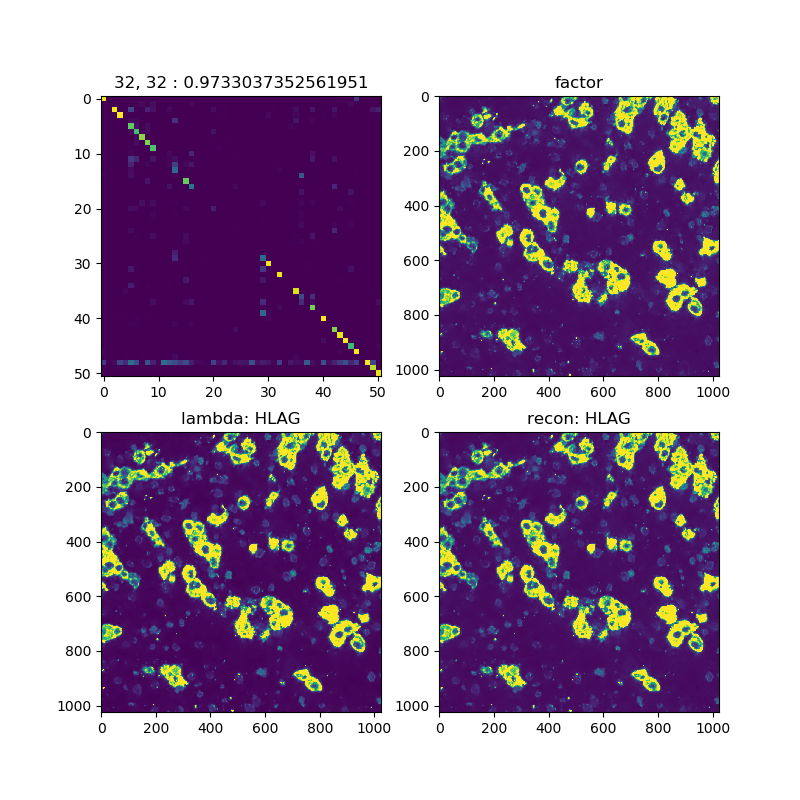

Text(0.5, 1.0, 'recon: HLAG')

In [30]:
factor_index = 32
lambda_index = 32

fig1 = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(decoder_mat[:,:,0,0].cpu())
plt.title(str(factor_index) + ', ' + str(lambda_index) + ' : ' + str(decoder_mat[factor_index,lambda_index,:,:].item()))

ax = plt.subplot(2,2,2)
plt.imshow(latents[0,factor_index,:,:].detach().cpu().numpy(), vmax=2)
plt.title('factor')

vmax = 2
plt.subplot(2,2,3, sharex=ax, sharey=ax)
plt.imshow(lambdas[lambda_index,:,:], vmin=0, vmax=vmax)
plt.title('lambda: ' + labels[lambda_index])

plt.subplot(2,2,4, sharex=ax, sharey=ax)
plt.imshow(recon[0,lambda_index,:,:].detach().cpu().numpy(), vmin=0, vmax=vmax)
plt.title('recon: ' + labels[lambda_index])

In [10]:
# fig2 = plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.imshow(lambdas[5,:,:])
# plt.subplot(1,2,2)
# plt.imshow(lambdas[5,:,:])

In [11]:
y = torch.rand([20,5])
y

tensor([[0.4249, 0.3369, 0.9610, 0.8352, 0.7020],
        [0.6887, 0.6219, 0.1516, 0.7721, 0.2946],
        [0.6851, 0.8369, 0.6300, 0.1622, 0.4867],
        [0.0632, 0.6472, 0.8063, 0.4741, 0.6225],
        [0.8610, 0.1330, 0.3855, 0.7088, 0.9061],
        [0.6145, 0.9976, 0.6204, 0.7211, 0.9504],
        [0.1785, 0.9994, 0.2961, 0.9735, 0.4289],
        [0.7193, 0.0417, 0.7149, 0.0072, 0.4846],
        [0.4419, 0.7956, 0.5515, 0.9143, 0.9565],
        [0.9500, 0.1116, 0.9724, 0.1045, 0.5168],
        [0.1524, 0.1173, 0.4425, 0.8333, 0.5660],
        [0.1876, 0.9344, 0.0018, 0.6405, 0.3324],
        [0.2815, 0.6033, 0.3870, 0.6015, 0.6888],
        [0.4160, 0.1775, 0.2171, 0.8997, 0.0047],
        [0.7115, 0.6022, 0.0306, 0.2782, 0.1004],
        [0.1236, 0.3545, 0.6685, 0.3956, 0.7339],
        [0.4734, 0.7588, 0.1090, 0.0711, 0.5819],
        [0.9853, 0.3377, 0.5865, 0.6360, 0.5633],
        [0.0132, 0.9898, 0.1980, 0.3077, 0.4694],
        [0.7220, 0.1465, 0.8866, 0.2833, 0.5882]])

In [12]:
ym = torch.mean(y,dim=0)
ym

tensor([0.4847, 0.5272, 0.4809, 0.5310, 0.5489])